# Demonstrate how to use DensityDist
Utilize a scipy.stats.rayleigh distribution to demonstrate

In [1]:
import pymc3 as pm
import seaborn as sns
import scipy
import scipy.stats
import numpy as np
import spacepy.toolbox as tb
import matplotlib.pyplot as plt
from theano import theano, tensor as tt

sns.set(font_scale=1.5)

## Given example
https://pymc3.readthedocs.io/en/latest/notebooks/normalizing_flows_overview.html?highlight=densitydist

In [2]:
from pymc3.distributions.dist_math import bound

def pot1(z):
    z = z.T
    return .5*((z.norm(2, axis=0)-2.)/.4)**2 - tt.log(tt.exp(-.5*((z[0]-2.)/.6)**2) +
                                                      tt.exp(-.5*((z[0]+2.)/.6)**2))


def cust_logp(z):
    # this works to cut things off, useful or not but 0 is a nature place a lot of times
    return bound(-pot1(z), z>-5, z<5) 
#     return -pot1(z)

with pm.Model() as pot1m:
    pm.DensityDist('pot1', logp=cust_logp, shape=(2,))
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pot1]
Sampling 2 chains, 6 divergences: 100%|██████████| 3000/3000 [00:01<00:00, 2076.96draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


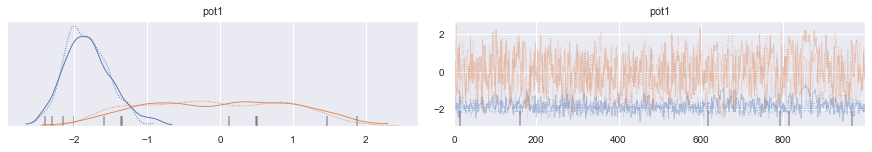

In [3]:
pm.traceplot(trace);

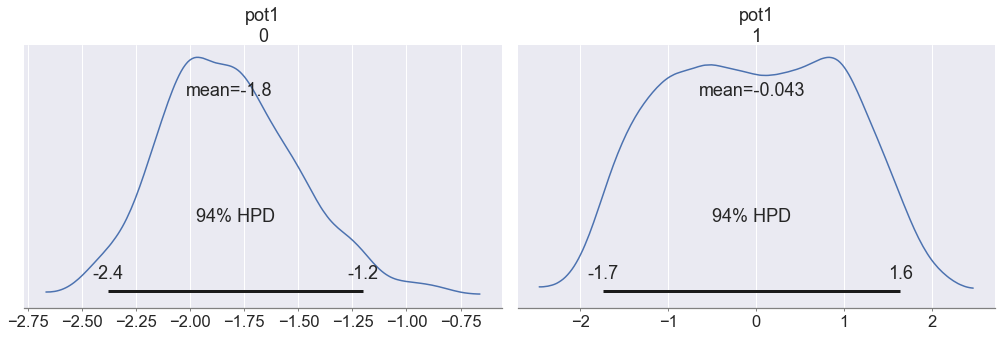

In [4]:
pm.plot_posterior(trace);

## Now can we do this from a histogram?

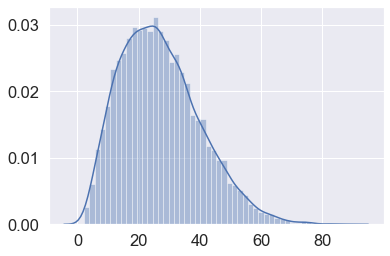

In [5]:
dist = scipy.stats.rayleigh(loc=2, scale=20)
rvs = dist.rvs(10000)
sns.distplot(rvs)

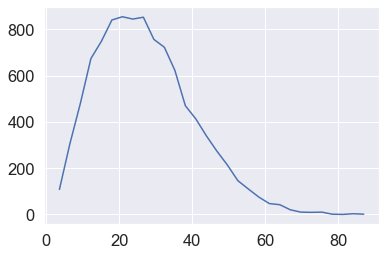

In [6]:
# need to make a callable function of the histogram of this. 
h, b = np.histogram(rvs, 30)
b = tb.bin_edges_to_center(b)
plt.plot(b, h)

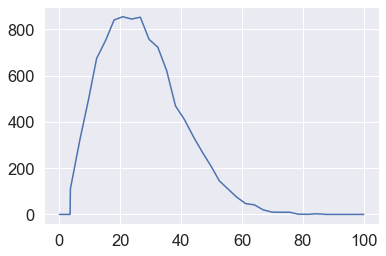

In [7]:
f = scipy.interpolate.interp1d(b,h, bounds_error=False, fill_value=0)
XX = np.linspace(0, 100, 1000)
plt.plot(XX, f(XX))


In [12]:
from theano.tensor import _shared

@theano.as_op(itypes=[theano.tensor.dscalar],otypes=[theano.tensor.dscalar])
def dens_fn(x):
    return tt.log(f(x) )
# dens_fn(_shared(np.linspace(-1, 5, 10)))

In [18]:
with pm.Model() as model:
    dens = pm.DensityDist('density', logp=dens_fn)
    trace = pm.sample(5000)
    

TypeError: For compute_test_value, one input test value does not have the requested type.
 
Backtrace when that variable is created:

  File "/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-132a24e86cb2>", line 2, in <module>
    dens = pm.DensityDist('density', logp=dens_fn)
  File "/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/pymc3/distributions/distribution.py", line 47, in __new__
    return model.Var(name, dist, data, total_size)
  File "/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/pymc3/model.py", line 922, in Var
    total_size=total_size, model=self)
  File "/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/pymc3/model.py", line 1373, in __init__
    self.logp_sum_unscaledt = distribution.logp_sum(self)
  File "/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/pymc3/distributions/distribution.py", line 124, in logp_sum
    return tt.sum(self.logp(*args, **kwargs))

The error when converting the test value to that variable type:
Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?

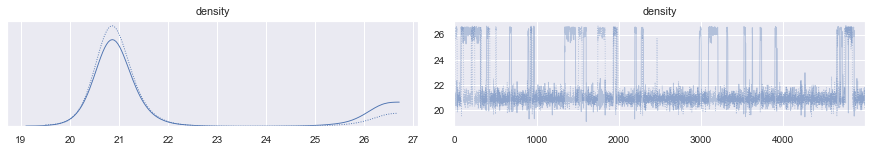

In [10]:
pm.traceplot(trace);

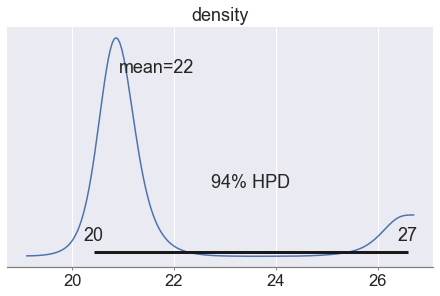

In [11]:
pm.plot_posterior(trace);